In [1]:
from keras_segmentation.models import unet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import re
import glob
from utils_segmentation import bb_intersection_over_union, build_hist, augmentation_images, create_annotations
import numpy as np

Using TensorFlow backend.


In [ ]:
# # data = pd.read_csv('data_fortnite.csv')
# data = pd.read_csv('data_fortnite.csv')

# # Let's decrease number of classes to 3 {'team place': 1, 'match_stat': 2, 'victory_royale': 3}

# data_3_classes = data[(data.labels==3)|(data.labels==4)|(data.labels==8)]
# #team place
# data_3_classes.labels = data_3_classes.labels.apply(lambda x: 1 if x==3 else x)
# #match stat
# data_3_classes.labels = data_3_classes.labels.apply(lambda x: 2 if x==4 else x)
# #victory royale
# data_3_classes.labels = data_3_classes.labels.apply(lambda x: 3 if x==8 else x)

# # save dataset
# data_3_classes.to_csv('data_fortnite_3_classes.csv')

In [4]:
data = pd.read_csv('data_fortnite_3_classes.csv')

In [5]:
n_cl = data.labels.unique().shape[0]

In [4]:
n_cl

3

In [ ]:
data.shape

## Create mask

In [ ]:
for f in data.fname.unique():
    img = cv2.imread('data_3_classes/img/'+f)
    mask = np.zeros(img.shape)
    F = data[data.fname==f]
    for cl in F['labels']:
        pts = F[data['labels']==cl][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)
        mask = cv2.fillPoly(mask,[pts],color=(cl,cl,cl))
    cv2.imwrite('data_3_classes/annotations/'+f.split('.')[0]+'.png',mask)

In [ ]:
f_name = 'data_3_classes/img/3AB6FC95D6_0.jpg'
m_name = 'data_3_classes/annotations/3AB6FC95D6_0.png'
img = cv2.imread(f_name)
msk = cv2.imread(m_name)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(msk*50)

In [ ]:
files = glob.glob('data_3_classes/img/*.jpg')
row = len(files)

In [ ]:
i=1
plt.figure(figsize=(16,60))
for f in data.fname.unique():
    img = cv2.imread('data_3_classes/img/'+f)
    msk = cv2.imread('data_3_classes/annotations/'+f.split('.')[0]+'.png')
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(img)
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(msk*50)

## Create dataset

In [ ]:
for f in data.fname.unique():
    img = cv2.imread('data_3_classes/img/'+f)
    seg = cv2.imread('data_3_classes/annotations/'+f.split('.')[0]+'.png')
    img_r = cv2.resize(img, (224,224))
    seg_r = cv2.resize(seg, (224,224))
    cv2.imwrite('data_3_classes/images_train/'+f.split('.')[0]+'.png',img_r)
    cv2.imwrite('data_3_classes/annotations_train/'+f.split('.')[0]+'.png',seg_r)

In [ ]:
img_path = 'data_3_classes/images_train/'
annot_path = 'data_3_classes/annotations_train/'
images = glob.glob('data_3_classes/images_train/*.png')
annotations = glob.glob('data_3_classes/annotations_train/*.png')
augmentation_images(images,annotations,img_path,annot_path)

##  Validation set

In [ ]:

!mv data_3_classes/images_train/0GD3EH8SIE_1*.png data_3_classes/validation/
!mv data_3_classes/images_train/KJPCNUM8J0_1*.png data_3_classes/validation/
!mv data_3_classes/annotations_train/0GD3EH8SIE_1*.png data_3_classes/annotation_validation/
!mv data_3_classes/annotations_train/KJPCNUM8J0_1*.png data_3_classes/annotation_validation/

## Model

In [6]:
model = unet.mobilenet_unet(n_classes=n_cl+1, input_height=224, input_width=224,)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.train(
    train_images =  "data_3_classes/images_train/",
    train_annotations = "data_3_classes/annotations_train/",
    validate = True,
    val_images = "data_3_classes/validation/",
    val_annotations = "data_3_classes/annotation_validation/",
    epochs=2
)

In [ ]:
model.save('fortnite_3_classes.h5')

In [ ]:
out_1 = model.predict_segmentation(inp="data_3_classes/images_train/3AB6FC95D6_0.png")
out_2 = model.predict_segmentation(inp="data_3_classes/images_train/AWEDPCEKOU_0.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('3AB6FC95D6_0')
plt.imshow(out_1)
plt.subplot(1,2,2)
plt.title('AWEDPCEKOU_0')
plt.imshow(out_2)

## Test of Model

In [ ]:
# file from alexandr
# select images from folder
# calc accuracy

In [7]:
model.load_weights('fortnite_3_classes.h5')

## Test IOU

In [ ]:
# #TBD -> decrease to 3 classes
# test_data = pd.read_csv('data_fortnite_test.csv')

# # Let's decrease number of classes to 3 {'team place': 1, 'match_stat': 2, 'victory_royale': 3}

# test_data_3_classes = test_data[(test_data.labels==3)|(test_data.labels==4)|(test_data.labels==8)]
# #team place
# test_data_3_classes.labels = test_data_3_classes.labels.apply(lambda x: 1 if x==3 else x)
# #match stat
# test_data_3_classes.labels = test_data_3_classes.labels.apply(lambda x: 2 if x==4 else x)
# #victory royale
# test_data_3_classes.labels = test_data_3_classes.labels.apply(lambda x: 3 if x==8 else x)

# # save dataset
# test_data_3_classes.to_csv('test_data_fortnite_3_classes.csv')

In [17]:
test_data = pd.read_csv('test_data_fortnite_3_classes.csv')

In [8]:
test_data.head()

bbox_x1  bbox_y1  bbox_x2  bbox_y2  bbox_x3  bbox_y3  bbox_x4  bbox_y4  \
0      482       51      870       17      792      147      401      167   
1     1056        1     1215        1     1215       18     1056       22   
2      713      661     2033      553     1745     1005      437     1085   
3     2681      493     3261      481     3253      577     2681      577   
4      735      149     1307       97     1189      291      601      337   

   labels             fname  img_type  
0       3  HN7ZE8WQ7K_1.jpg         5  
1       2  HN7ZE8WQ7K_1.jpg         5  
2       3  LRDRCXLBOK_0.jpg         5  
3       2  LRDRCXLBOK_0.jpg         5  
4       3  M7YRPKB7RE_1.jpg         5

In [9]:
test_data.labels.unique()

array([3, 2, 1])

In [10]:
#number of classes on image
n_classes = 2

In [ ]:
# for f in test_data.fname.unique():
#     img = cv2.imread(raw_dir+f)
#     cv2.imwrite('data/test_imgs/'+f, img)

In [ ]:
img_folder = 'data_3_classes/test_imgs/'
annotation_folder = 'data_3_classes/test_annotations/'
create_annotations(test_data,img_folder, annotation_folder)

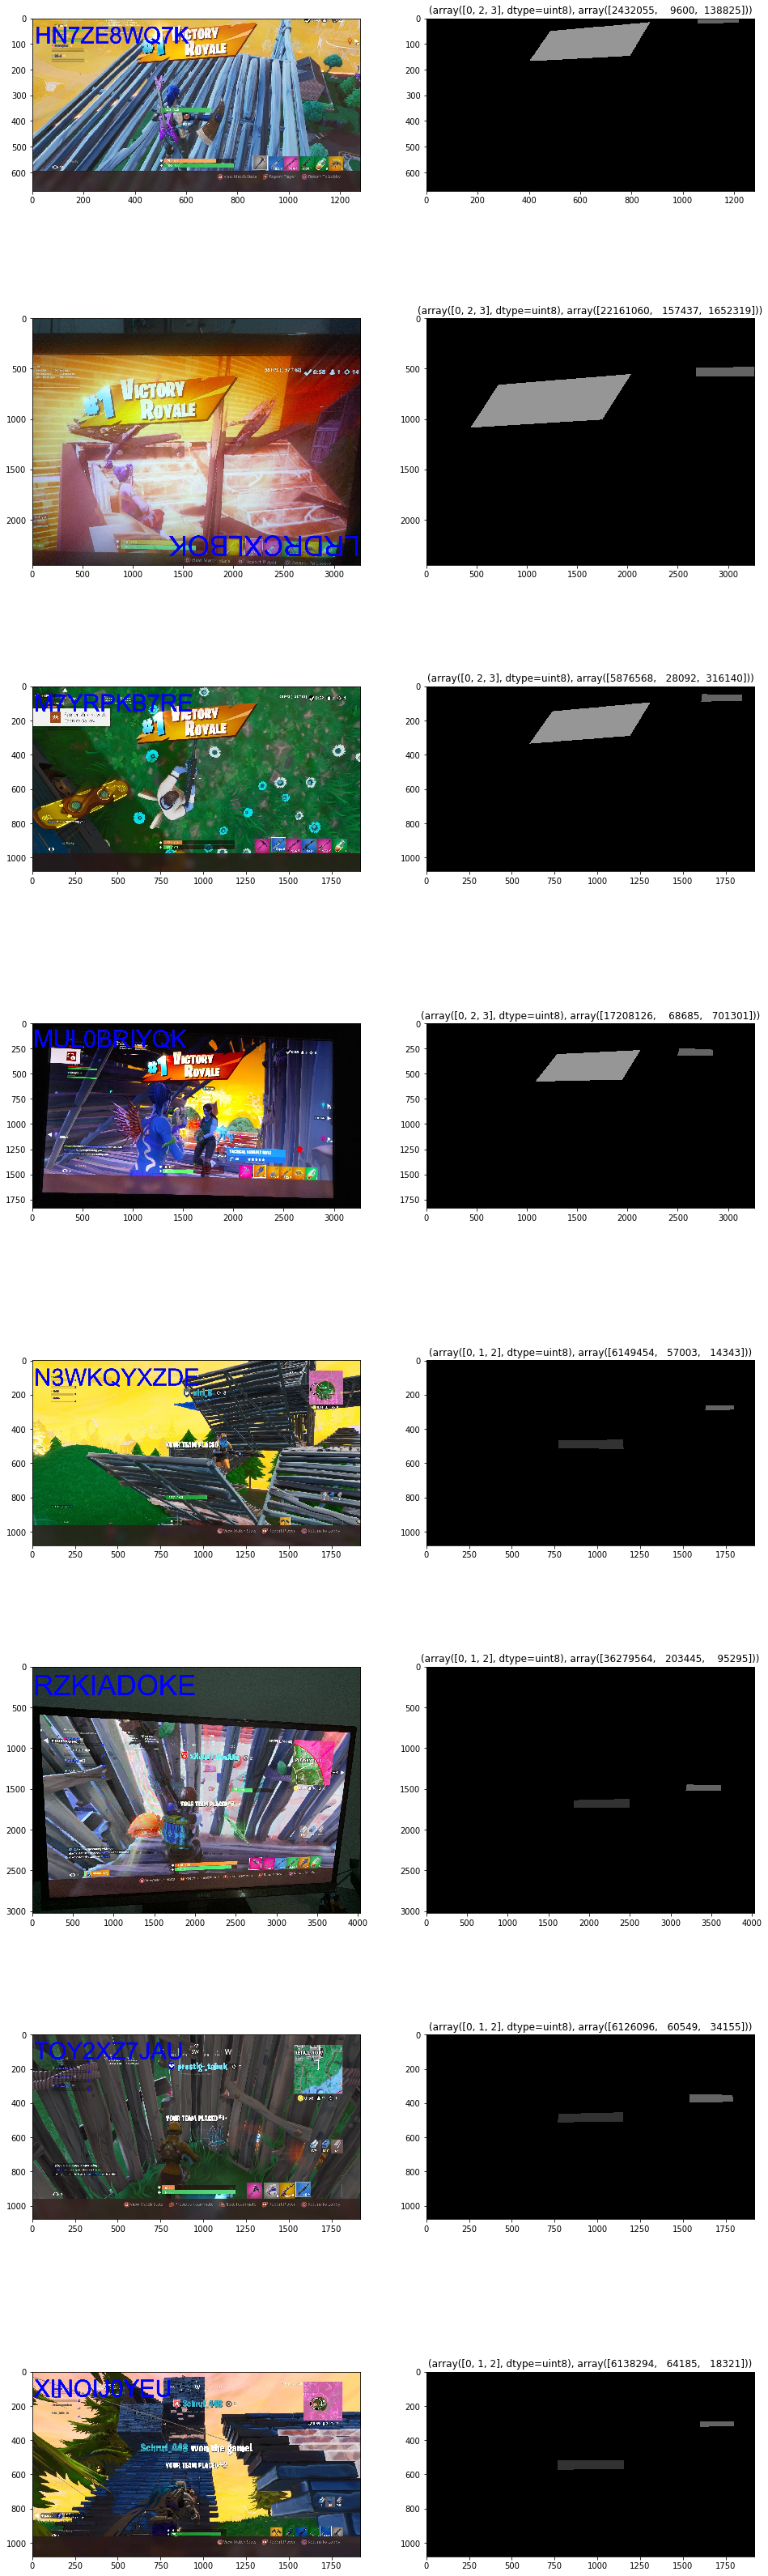

In [11]:
test_files = glob.glob('data_3_classes/test_imgs/*.jpg')
row = len(test_files)
i=1

plt.figure(figsize=(16,60))
for f in test_data.fname.unique():
    img = cv2.imread('data_3_classes/test_imgs/'+f)
    msk = cv2.imread('data_3_classes/test_annotations/'+f.split('.')[0]+'.png')
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(img)
    plt.subplot(row,2,i)
    plt.title(np.unique(msk,return_counts=True))
    i+=1
    plt.imshow(msk*50)

In [20]:
def detect_classes_v(img,n_classes):
    """
    Detect classes that are most represemted on mask
    """
    labels, counts = np.unique(img, return_counts=True)
    labels = labels[1:]
    counts = counts[1:]

    inds = np.argsort(counts)
    list_classes = [labels[inds[-i]] for i in range(1, len(labels) + 1)]
        
    return list_classes

def find_segments_v(mask_img,cls):
    """
    Find segments on mask
    Inputs:
    mask_img - segmentation mask image from model
    cls - labels of classes that are on image
    Outputs:
    segments - segmnets that were found

    """
    thresh_1 = 1
    segments={}
    for cl in cls:
        
        cols = np.sum(mask_img==cl,axis=1)
        rows = np.sum(mask_img==cl,axis=0)
        col_cond1= (cols>=np.mean(cols[cols>thresh_1])/1.5)
        row_cond1= (rows>=np.mean(rows[rows>thresh_1])/1.5)
        
        col_indecies = np.where(col_cond1)[0]
        row_indecies = np.where(row_cond1)[0]

        x1 = row_indecies[0]
        y1 = col_indecies[0]
        x2 = row_indecies[-1]
        y2 = col_indecies[-1]
        
        segments[cl] = [(x1,y1),(x2,y2)]
    return segments

def crop_rect_v(im, rect, scaler={'h': 1, 'w': 1}):
    """
    Crop original image by segments.
    Input:
    im - raw image
    rect - rectangle for cropping
    scaler - scaler for rectangle
    Return:
    crop_img - crop segment with original resolution
    coordinates - coordinates of crop rectangle
    """
    k_w=5
    k_h=6
    
    h1 = int(rect[0][1]*scaler['h'])
    w1 = int(rect[0][0]*scaler['w'])
    h2 = int(rect[1][1]*scaler['h'])
    w2 = int(rect[1][0]*scaler['w'])
    
    h1_ = h1-k_h if (h1-k_h)>0 else 0
    w1_ = w1-k_w if (w1-k_w)>0 else 0
    h2_ = h2+k_h if (h2+k_h)<im.shape[1] else im.shape[1]
    w2_ = w2+k_w if (w2+k_w)<im.shape[1] else im.shape[1]
    
    crop_img = im[h1_:h2_, w1_:w2_]
    #[(x1,y1),(x2,y2)]
    coordinates = [(w1_,h1_),(w2_,h2_)]        
    return crop_img, coordinates

In [171]:
def IOU_list_files_v(test_data,model,img_folder='data_3_classes/test_imgs/',
                   annotation_folder = 'data_3_classes/test_annotations/',
                  size=(224,224)):

    """
    For testing accuracy of model. I use metric IOU.
    Input:
    test_data - data frame with columns:  'fname','labels','bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4'
    img_folder - folder with test images

    """
    m=np.array([[True,True],[False,False],[True,True],[False,False]])
    
    predicted_boxes = {}
    real_boxes = {}
    IOUs = {}
    k=1
    plt.figure(figsize=(15,60))
    for f in test_data.fname.unique():
        n_classes = 2

        img = cv2.imread(img_folder+f)
        img_r = cv2.resize(img, size)

        out = model.predict_segmentation(img_r)
        
        plt.subplot(8,2,k)
        plt.title(np.unique(out,return_counts=True))
        plt.imshow(out)
        k+=1
       #cv2.imshow(f'{f}',out*50)
        h_scale = img.shape[0] / out.shape[0]
        w_scale = img.shape[1] / out.shape[1]
        scaler = {'h': h_scale, 'w': w_scale, }
        list_cls = detect_classes_v(out,n_classes)
        
        rects = find_segments_v(out,list_cls)
        img_r_2 = cv2.resize(img_r, (112,112))
        for r in rects:
            cv2.rectangle(img_r_2,*rects[r],(255,255,0),2)
        
        plt.subplot(8,2,k)
        plt.title(r)
        plt.imshow(img_r_2)
        k+=1

        segments = {}
        for r in rects:
            crop_img, coordinates = crop_rect_v(img, rects[r], scaler=scaler)
            segments[r]={'data': crop_img, 'coordinates':coordinates}

        predicted_boxes[f] = segments

        real_boxes[f]={}
        IOUs[f] = {}

        for l in test_data[test_data.fname==f].labels:
            pts=test_data[(test_data.fname==f)&(test_data.labels==l)][['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'bbox_x3', 'bbox_y3',
       'bbox_x4', 'bbox_y4']].values[0].astype('int').reshape(4,2)
            real_boxes[f][l] = pts[m]
            
            
            if segments.get(l,0):
                
                boxA= np.ravel(segments[l]['coordinates'])
                boxB = pts[m]

                IOUs[f][l] = bb_intersection_over_union(boxA, boxB)
            else:
                IOUs[f][l] = 0
            
    return IOUs

{'HN7ZE8WQ7K_1.jpg': {3: 0.7431210740238946, 2: 0.4805677593781683},
 'LRDRCXLBOK_0.jpg': {3: 0.8552063236098713, 2: 0.4721714258920617},
 'M7YRPKB7RE_1.jpg': {3: 0.7028279467680608, 2: 0.547945205479452},
 'MUL0BRIYQK_0.jpg': {3: 0.7662762946106455, 2: 0.29519930889793905},
 'N3WKQYXZDE_2.jpg': {1: 0.8791242207693477, 2: 0.5322824081838001},
 'RZKIADOKE_1.jpg': {1: 0, 2: 0},
 'TOY2XZ7JAU_2.jpg': {1: 0.35928816033234157, 2: 0.6653849368887402},
 'XINOIJ0YEU_0.jpg': {1: 0.47767201979118623, 2: 0.022676919066857815}}

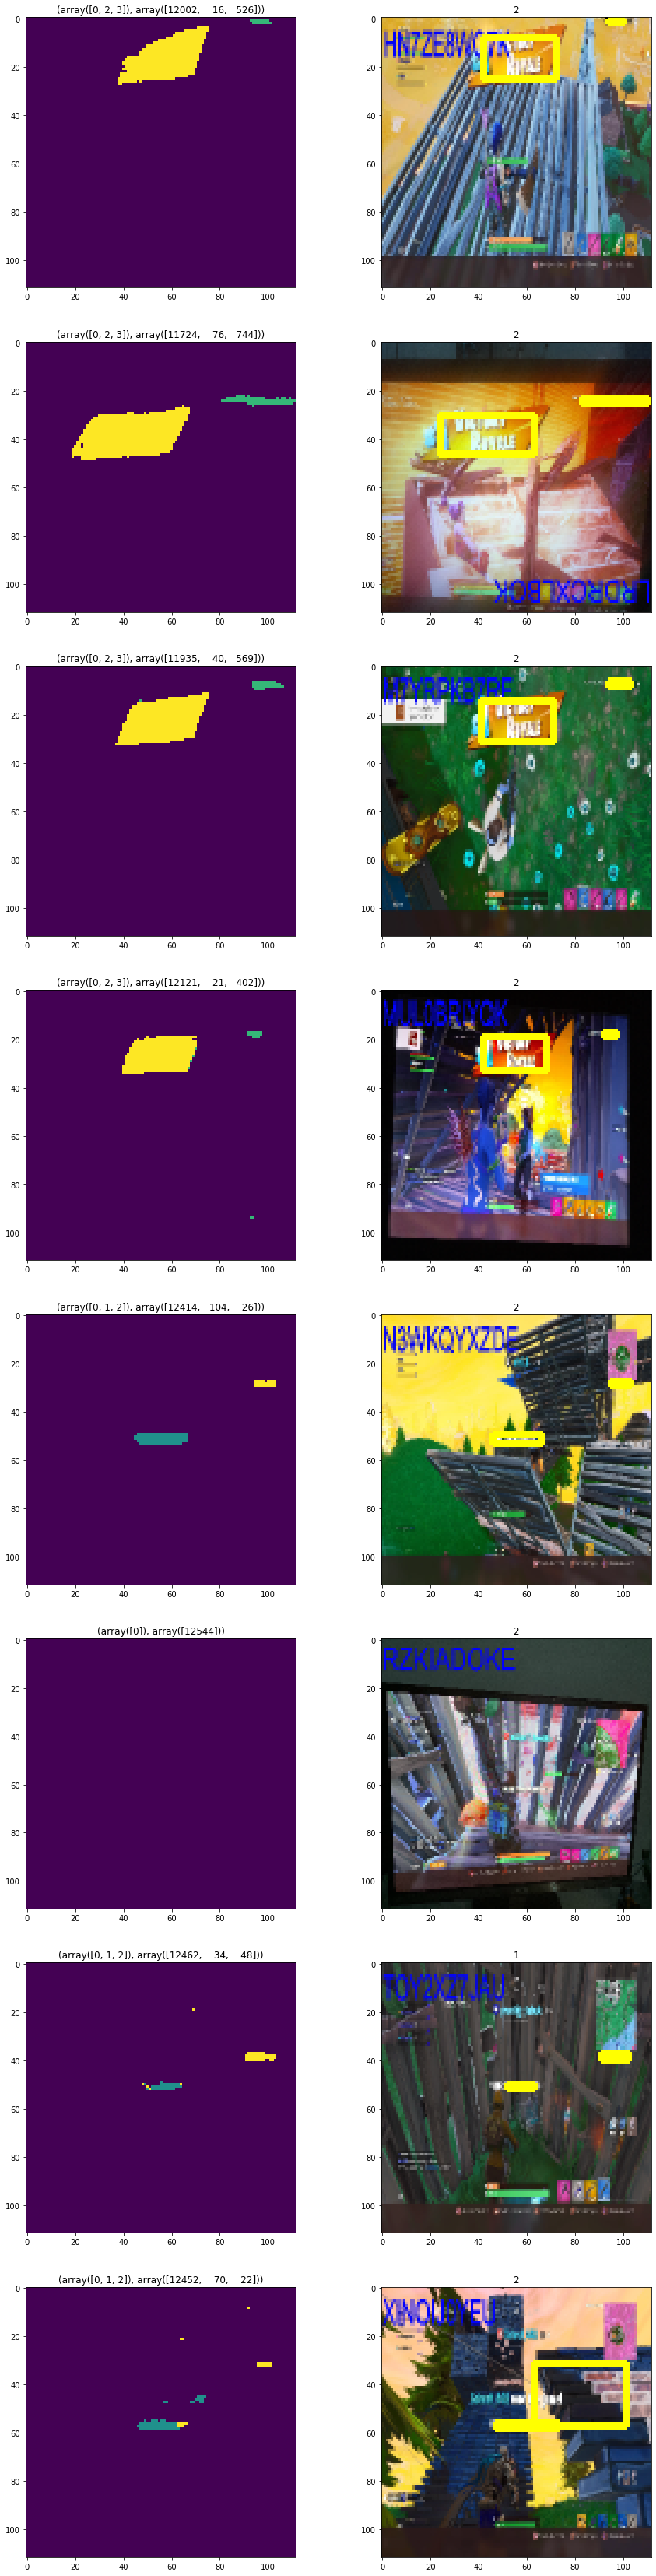

In [172]:
IOUs = IOU_list_files_v(test_data,model,img_folder='data_3_classes/test_imgs/',
                   annotation_folder = 'data_3_classes/test_annotations/',
                  size=(224,224))
IOUs

In [168]:
ACC = pd.DataFrame.from_dict(IOUs, orient='index')
ACC.mean()

3    0.766858
2    0.377028
1    0.429021
dtype: float64

In [155]:
# Visualize results for each image

In [24]:
def analysis_v(f, model, path='data_3_classes/test_imgs/', size=(224,224), test_data=test_data):
    """
    Visualization of work of model
    """
    n_classes = 2
    img = cv2.imread(path+f)
    img_r = cv2.resize(img, size)
    img_r_mask = cv2.resize(img, (int(size[0]/2),int(size[1]/2)))

    out = model.predict_segmentation(img_r)
    
    if len(np.unique(out))>1:

        h_scale = img.shape[0] / out.shape[0]
        w_scale = img.shape[1] / out.shape[1]
        scaler = {'h': h_scale, 'w': w_scale, }

        list_cls = detect_classes_v(out,n_classes)
        rects = find_segments_v(out,list_cls)
        segments = []
        for r in rects:
            crop_img, coordinates = crop_rect_v(img, rects[r], scaler=scaler)
            segments.append({'label': r, 'data': crop_img, 'coordinates':coordinates})

            cv2.rectangle(img_r_mask,*rects[r],(255,255,0),2)

        print(f'Find segments: {len(segments)}')
        plt.figure(figsize=(8,8))
        plt.subplot(2,2,1)
        plt.title(f"Label: {segments[0]['label']}")
        plt.imshow(segments[0]['data'])
        plt.subplot(2,2,2)
        if  len(segments)>1:
            plt.title(f"Label: {segments[1]['label']}")
            if segments[1]['data'].any():
                plt.imshow(segments[1]['data'])
        else:
            plt.title(f"Label: None")
#         plt.subplot(2,2,3)
#         if  len(segments)>2:
#             plt.title(f"Label: {segments[2]['label']}")
#             plt.imshow(segments[2]['data'])
#         else:
#             plt.title(f"Label: None")
        plt.subplot(2,2,3)
        plt.title(f"mask")
        plt.imshow(out)
        plt.subplot(2,2,4)
        plt.title(f"image")
        plt.imshow(img_r_mask)
    else:
        print('No class detection')
    return out

In [157]:
#test_data

Find segments: 2


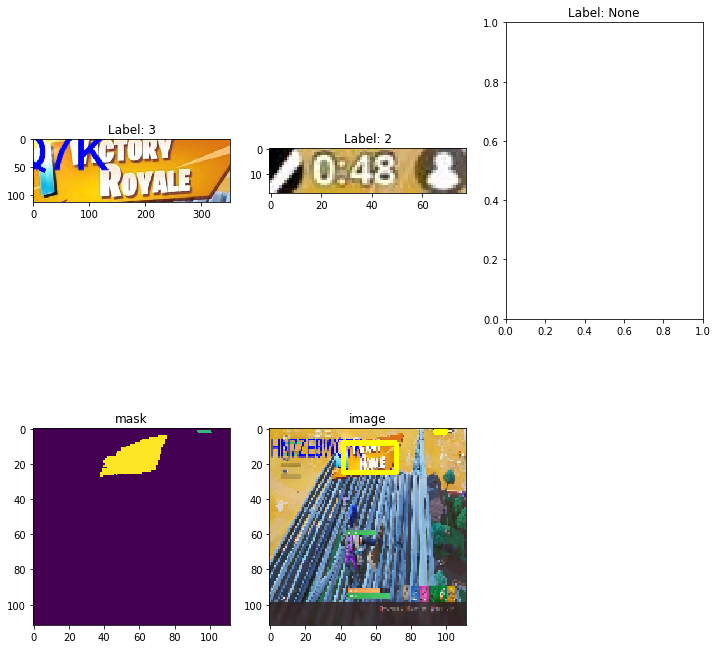

In [158]:
fname='HN7ZE8WQ7K_1.jpg'
msk = analysis_v(f=fname, model=model)

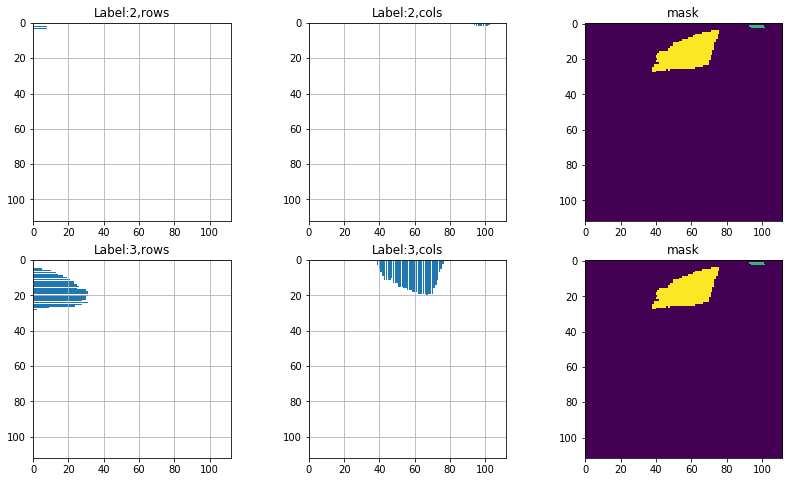

In [159]:
build_hist(msk,[2,3])

Find segments: 2


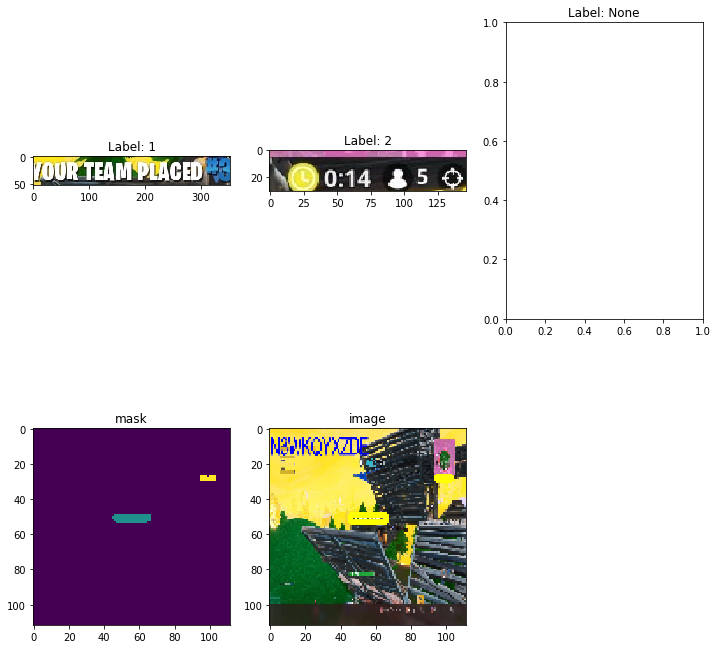

In [160]:
fname='N3WKQYXZDE_2.jpg'
msk = analysis_v(f=fname, model=model)

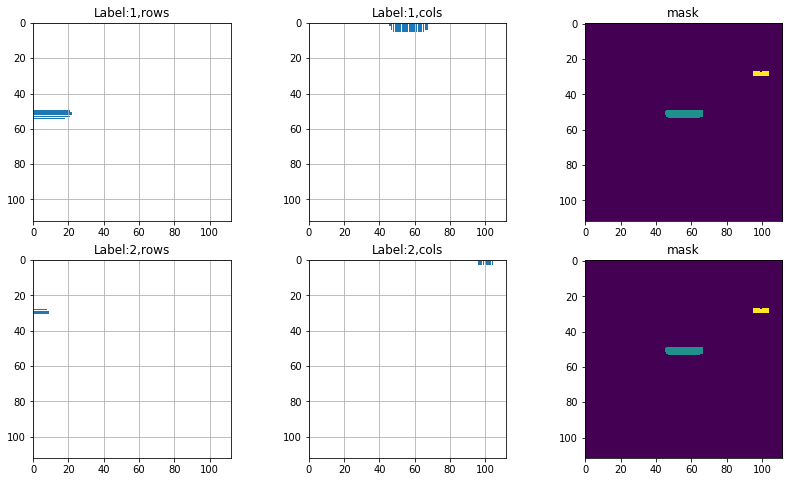

In [161]:
build_hist(msk,[1,2])

In [162]:
fname='RZKIADOKE_1.jpg'
msk = analysis_v(f=fname, model=model)

No class detection


Find segments: 2


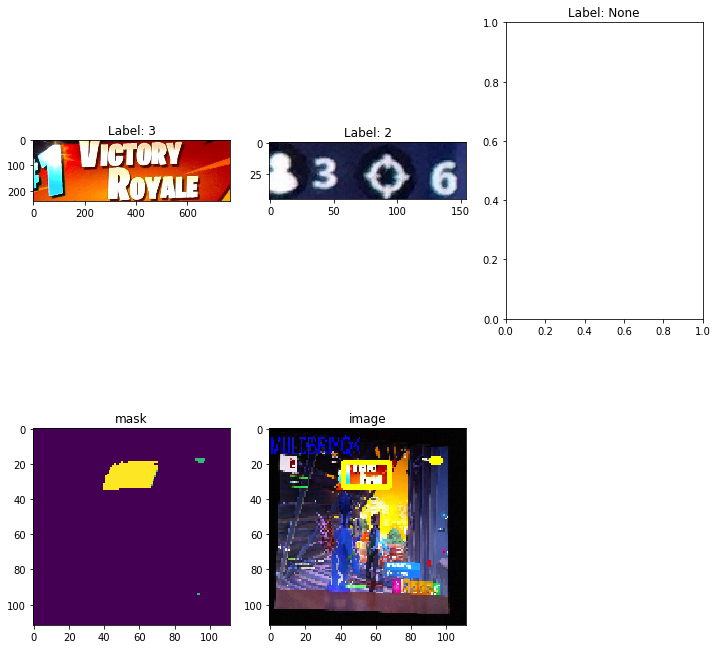

In [163]:
fname='MUL0BRIYQK_0.jpg'
msk = analysis_v(f=fname, model=model)

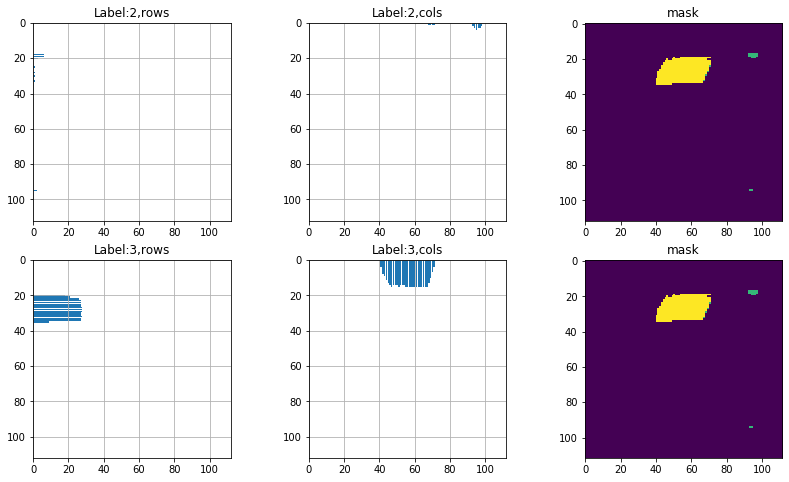

In [164]:
build_hist(msk,[2,3])

Find segments: 2


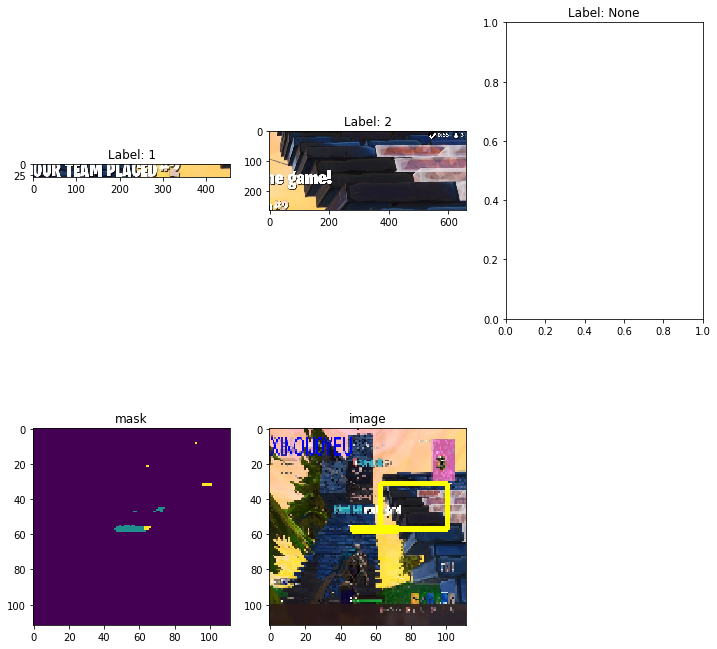

In [165]:
fname='XINOIJ0YEU_0.jpg'
msk = analysis_v(f=fname, model=model)

In [ ]:
#TBD
# detect shape of rectangle for classes: 1 and 3. Increase to expected shape
# add to train dayaset image with fail detection, change to good sample
# good idea was to increase dataset to 10 images pear class

## System test

In [8]:
system_test_data = pd.read_csv('data_3_classes/data_fortnite_3_classes_system_test.csv')
system_test_data.head()

fname                         text
0  0GD3EH8SIE_1.jpg    {'place': 17, 'kills': 1}
1  0L1EIKM8SU_0.jpg  {'place': None, 'kills': 5}
2  3AB6FC95D6_0.jpg     {'place': 4, 'kills': 5}
3  4BF14869E1_0.jpg    {'place': 13, 'kills': 1}
4  8A9B87F189_1.jpg     {'place': 1, 'kills': 8}

In [12]:
system_test_files

['data_3_classes/system_tes_imgs/146073D685_0.jpg',
 'data_3_classes/system_tes_imgs/ACDD33A017_0.jpg',
 'data_3_classes/system_tes_imgs/AD58BB1460_1.jpg',
 'data_3_classes/system_tes_imgs/3AB6FC95D6_0.jpg',
 'data_3_classes/system_tes_imgs/KJPCNUM8J0_1.jpg',
 'data_3_classes/system_tes_imgs/8A9B87F189_1.jpg',
 'data_3_classes/system_tes_imgs/4BF14869E1_0.jpg',
 'data_3_classes/system_tes_imgs/5141C3A3F8_0.jpg',
 'data_3_classes/system_tes_imgs/0L1EIKM8SU_0.jpg',
 'data_3_classes/system_tes_imgs/AWEDPCEKOU_0.jpg',
 'data_3_classes/system_tes_imgs/0GD3EH8SIE_1.jpg']

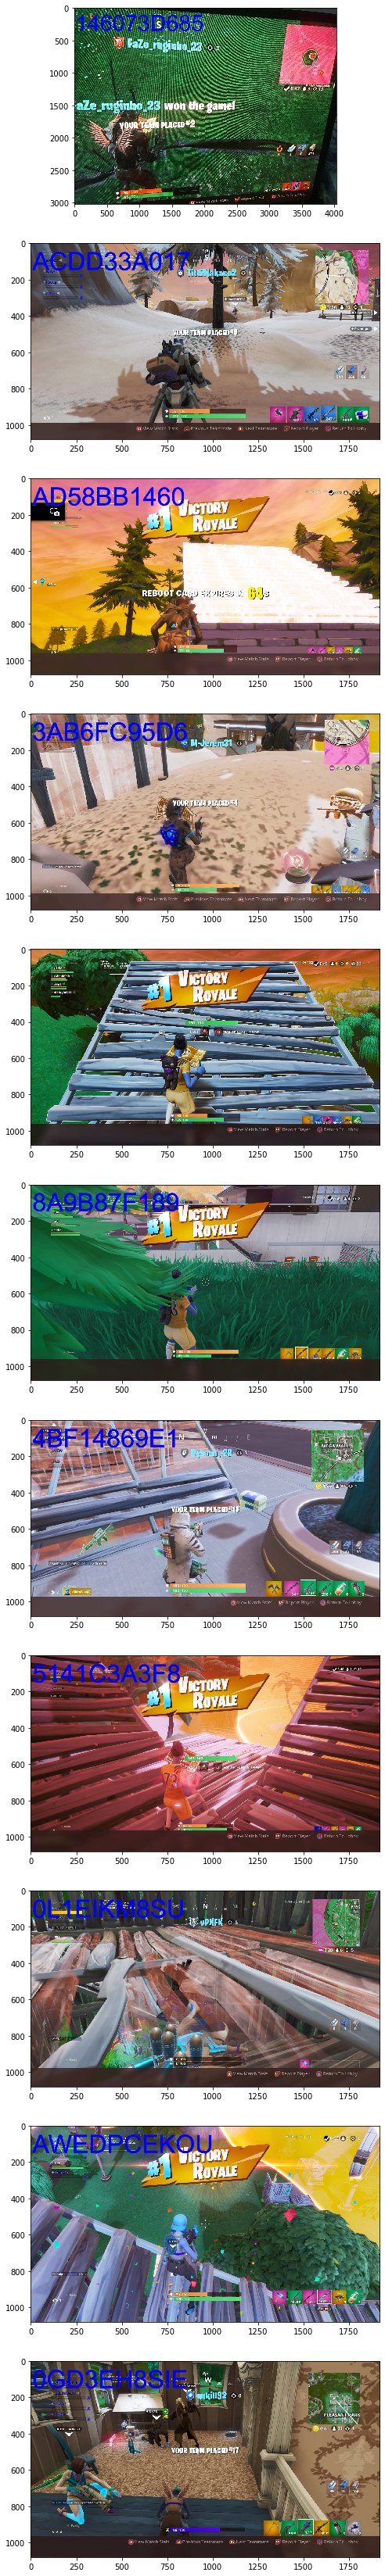

In [13]:
system_test_files = glob.glob('data_3_classes/system_tes_imgs/*.jpg')
row = len(system_test_files)
i=1

plt.figure(figsize=(16,60))
for f in system_test_files:
    img = cv2.imread(f)
#     msk = cv2.imread('data_3_classes/test_annotations/'+f.split('.')[0]+'.png')
    plt.subplot(row,1,i)
    i+=1
    plt.imshow(img)

Find segments: 2


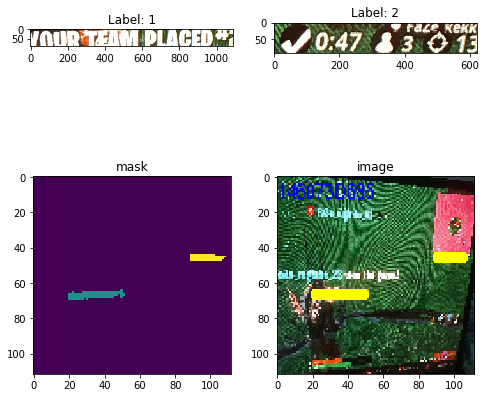

In [25]:
f = '146073D685_0.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

Find segments: 2


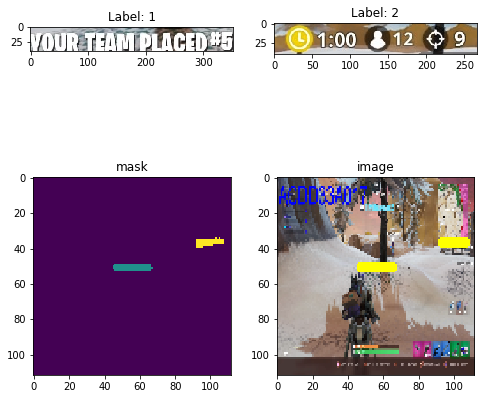

In [26]:
f = 'ACDD33A017_0.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

Find segments: 2


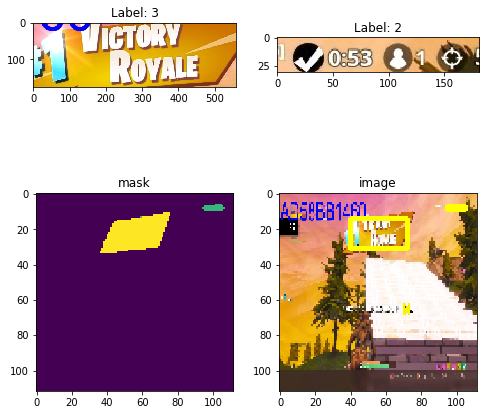

In [27]:
f = 'AD58BB1460_1.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

Find segments: 2


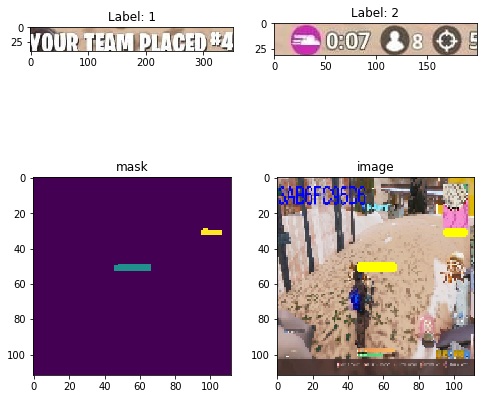

In [28]:
f = '3AB6FC95D6_0.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

Find segments: 2


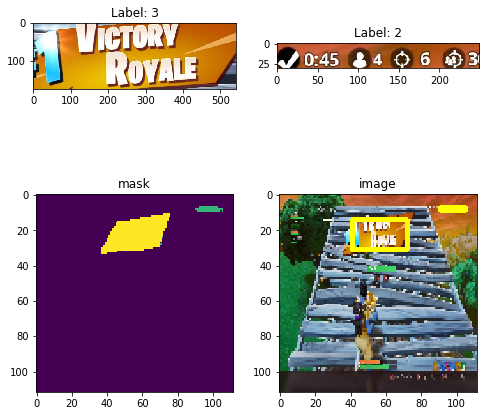

In [29]:
f = 'KJPCNUM8J0_1.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

Find segments: 2


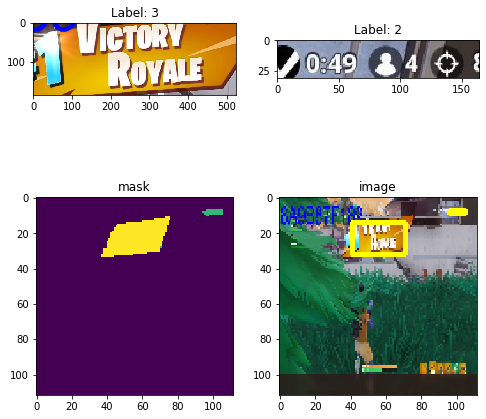

In [30]:
f = '8A9B87F189_1.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)